In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
import os
import random
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps, Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.version.VERSION

'2.6.0'

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

In [5]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [6]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(2, 1, padding="same", activation="sigmoid")(decoder_4)
    #out = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(decoder_4)
    model = Model(input1, out)
    return model

In [7]:
input_shape = (256, 256, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
input_dir = "C:\\Users\\Sozan\\Desktop\\InputsRGB"
target_dir = "C:\\Users\\Sozan\\Desktop\\Labels"
exp_dir = "C:\\Users\\Sozan\\Desktop\\InputsRGB"

img_size = (256, 256)
num_classes = 1
batch_size = 4

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

experimental_img_paths = sorted(
    [
        os.path.join(exp_dir, fname)
        for fname in os.listdir(exp_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 6172
C:\Users\Sozan\Desktop\InputsRGB\image(1).jpg | C:\Users\Sozan\Desktop\Labels\image(1).png
C:\Users\Sozan\Desktop\InputsRGB\image(10).jpg | C:\Users\Sozan\Desktop\Labels\image(10).png
C:\Users\Sozan\Desktop\InputsRGB\image(100).jpg | C:\Users\Sozan\Desktop\Labels\image(100).png
C:\Users\Sozan\Desktop\InputsRGB\image(1000).jpg | C:\Users\Sozan\Desktop\Labels\image(1000).png
C:\Users\Sozan\Desktop\InputsRGB\image(1001).jpg | C:\Users\Sozan\Desktop\Labels\image(1001).png
C:\Users\Sozan\Desktop\InputsRGB\image(1002).jpg | C:\Users\Sozan\Desktop\Labels\image(1002).png
C:\Users\Sozan\Desktop\InputsRGB\image(1003).jpg | C:\Users\Sozan\Desktop\Labels\image(1003).png
C:\Users\Sozan\Desktop\InputsRGB\image(1004).jpg | C:\Users\Sozan\Desktop\Labels\image(1004).png
C:\Users\Sozan\Desktop\InputsRGB\image(1005).jpg | C:\Users\Sozan\Desktop\Labels\image(1005).png
C:\Users\Sozan\Desktop\InputsRGB\image(1006).jpg | C:\Users\Sozan\Desktop\Labels\image(1006).png


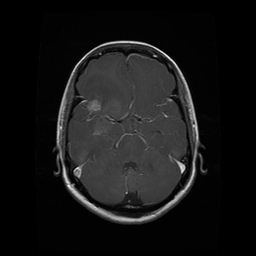

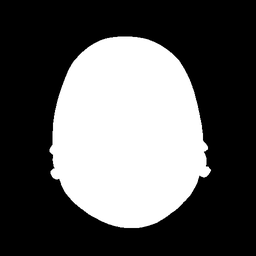

In [9]:
# Display input image #7
display(Image.open(input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(Image.open(target_img_paths[9]))
display(img)

In [10]:
class BrainMRI(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            tmp = np.expand_dims(img, 2)
            y[j] = np.where( tmp > 0, 1, 0)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y

In [16]:
# Split our img paths into a training and a validation set
val_samples = int(len(input_img_paths)*0.20)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = BrainMRI(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = BrainMRI(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [2]:
base_folder = "C:\\Users\\Sozan\\Desktop\\"
timestr = time.strftime("%Y%m%d-%H%M%S") 
#os.mkdir(base_folder + "logs",mode = 0o666)

In [20]:
logdir = os.path.join(base_folder + "logs/",timestr)
# convert the history.history dict to a pandas DataFrame:  
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint(logdir + "brainMRI_segmentation.h5", save_best_only=True),
    keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]  

In [21]:
# Train the model, doing validation at the end of each epoch.
epochs = 10
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
1234/1234 [==============================] - 319s 248ms/step - loss: 0.0732 - val_loss: 0.0511
Epoch 2/10
1234/1234 [==============================] - 299s 243ms/step - loss: 0.0445 - val_loss: 0.0490
Epoch 3/10
1234/1234 [==============================] - 301s 244ms/step - loss: 0.0354 - val_loss: 0.0332
Epoch 4/10
1234/1234 [==============================] - 300s 243ms/step - loss: 0.0309 - val_loss: 0.0286
Epoch 5/10
1234/1234 [==============================] - 299s 242ms/step - loss: 0.0281 - val_loss: 0.0346
Epoch 6/10
1234/1234 [==============================] - 300s 243ms/step - loss: 0.0261 - val_loss: 0.0273
Epoch 7/10
1234/1234 [==============================] - 301s 244ms/step - loss: 0.0247 - val_loss: 0.0297
Epoch 8/10
1234/1234 [==============================] - 299s 243ms/step - loss: 0.0233 - val_loss: 0.0236
Epoch 9/10
1234/1234 [==============================] - 298s 242ms/step - loss: 0.0222 - val_loss: 0.0250
Epoch 10/10
1234/1234 [=======================

In [25]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = logdir + 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = logdir + 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [26]:
# Generate predictions for all images in the validation set
val_gen = BrainMRI(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

In [27]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

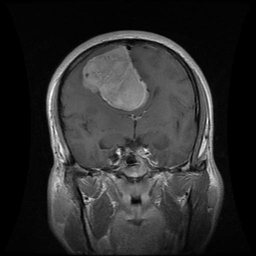

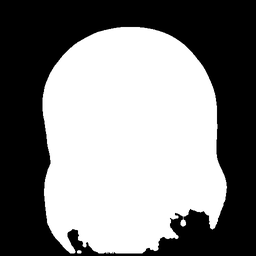

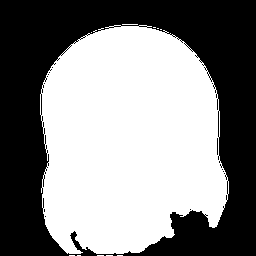

In [33]:
# Display results for validation image #10
i = 2

# Display input image
display(Image.open(val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [11]:
new_model = tf.keras.models.load_model('C:\\Users\\Sozan\\Desktop\\logs\\20211006-161701\\brainMRI_segmentation.h5')

In [21]:
# Split our img paths into a training and a validation set
val_samples = 100
random.Random(1337).shuffle(experimental_img_paths)
val_input_img_paths = experimental_img_paths[:200]
val_target_img_paths = experimental_img_paths[:200]

val_gen = BrainMRI(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [22]:
%%time
# Generate predictions for all images in the validation set
val_preds = new_model.predict(val_gen)

Wall time: 3.43 s


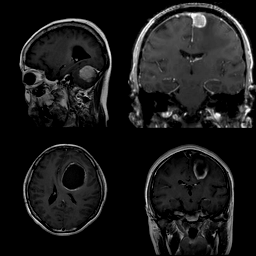

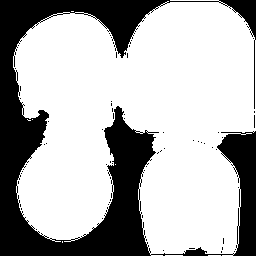

In [29]:
# Display results for validation image #10
i = 0

# Display input image
display(Image.open(val_input_img_paths[i]))

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

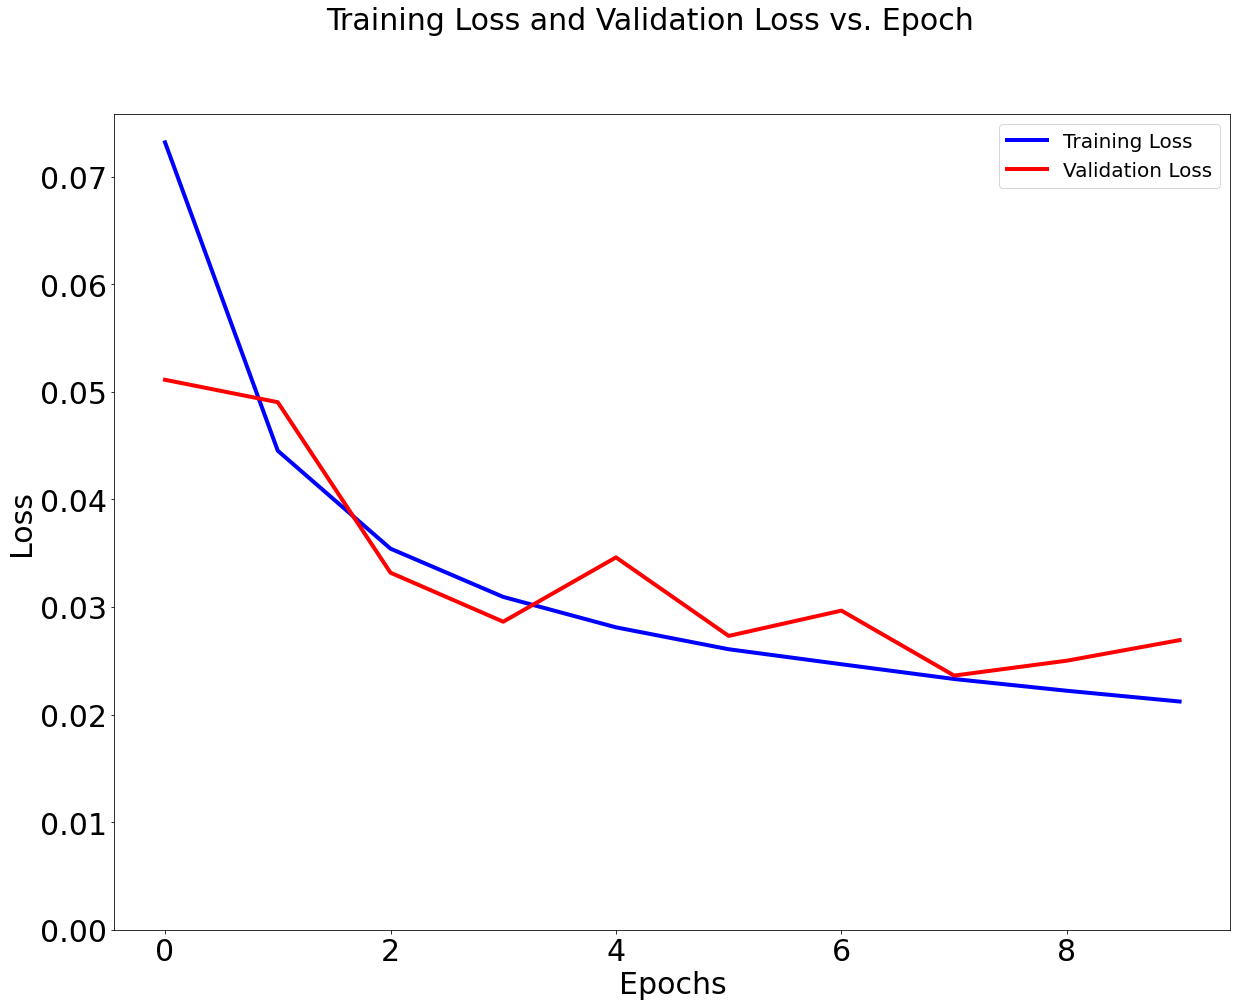

In [12]:
# Plotting Function
history = pd.read_csv(base_folder + '\\logs\\20211006-161701\\history.csv')

title = 'Training Loss and Validation Loss vs. Epoch '

file_name = "UNet.loss.svg" 

matplotlib.rc('xtick', labelsize=30)     
matplotlib.rc('ytick', labelsize=30)

fig = plt.figure(figsize = (20,15))
fig.suptitle(title, fontsize=30)
ax = plt.subplot(111)
plt.rc('legend',fontsize=20) # using a size in points
ax.plot(np.arange(len(history)), history['loss'], 'b-',label='Training Loss', linewidth = 4.0)
ax.plot(np.arange(len(history)), history['val_loss'], 'r-', label='Validation Loss', linewidth = 4.0)
plt.xlabel("Epochs",fontsize = 30)
plt.ylabel("Loss", fontsize = 30)
plt.ylim(bottom=0.)
ax.legend()
plt.savefig(base_folder + file_name, format='svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()